# GeoTrajGAN

This model is heavily based on GeoPointGAN [1].
However, we tried to adapt the model to generate trajectories instead of point clouds.

[1] T. Cunningham, K. Klemmer, H. Wen, and H. Ferhatosmanoglu,
“GeoPointGAN: Synthetic Spatial Data with Local Label Differential Privacy.”
arXiv, May 18, 2022. doi: 10.48550/arXiv.2205.08886.

In [1]:
%load_ext autoreload
%autoreload 2
import os


RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # Move to default colab folder
    %cd /content
    # Check if repository is already cloned
    if not os.path.isdir("stg"):
        # Clone repository
        !git clone https://github.com/erik-buchholz/SoK-TrajGen.git stg
    # Change to repository directory
    %cd stg
    # Only install requirements not already installed by Colab
    !pip install opacus haversine
    # SLOW: Only execute the following line if you encounter an error regarding a package not being installed
    # !pip install -r requirements.txt
else:
    import sys
    sys.path.append('..')  # Required for finding the `stg` module

In [2]:
import torch

from stg.datasets import get_dataset

import os
import logging
import random

import pandas as pd
import numpy as np
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from stg.datasets.padding import pad_feature_first, ZeroPadding

from stg import config
from stg.utils.helpers import get_ref_point, get_scaling_factor
from stg.utils.logger import configure_root_loger
from stg.utils import helpers, visualise, data
from stg.datasets.base_dataset import DatasetModes
from stg.models import GeoTrajGAN
# Load PyTorch Dataset
from stg.datasets.fs_nyc import FSNYCDataset, PATH_ALL
from stg.metrics import compute_list_differences as count_diff_in_list


configure_root_loger(logging_level=logging.INFO)

<RootLogger root (INFO)>

In [3]:
# Parameters
GPU=0
batch_size = 256

## FourSquare Dataset Point

In [4]:
fs_dataset = get_dataset(
    dataset_name="fs",
    mode=DatasetModes.ALL,
    latlon_only=True,
    normalize=True,
    return_labels=True,
    keep_original=False
)

print("Training Samples:\t\t\t\t", len(fs_dataset))
print("Reference Point:\t\t\t\t", fs_dataset.reference_point)
print("Scaling Factor:\t\t\t\t\t", fs_dataset.scale_factor)

fs_loader = DataLoader(
    fs_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=ZeroPadding(return_len=True, return_labels=True)
)
print("Number of Batches per epoch:\t", len(fs_loader))
print("Shape of a Batch:\t\t\t\t", next(iter(fs_loader))[0].shape)

# Expected Output:
# Reference Point:	 [-73.977705979516, 40.76959209333479]
# Scaling Factor:    [0.29193802048399675, 0.21873962593050322]

[2024-02-04 16:02:13,552][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/all_latlon.csv'. (fs_nyc.py:85) 
Training Samples:				 3079
Reference Point:				 [-73.977705979516, 40.76959209333479]
Scaling Factor:					 [0.29193802048399675, 0.21873962593050322]
Number of Batches per epoch:	 12
Shape of a Batch:				 torch.Size([256, 113, 2])


In [5]:
# Point Model
MODEL_NAME = "Foursquare-Point-GTG-Baseline"
N_EPOCHS = 1000

point_gan_fs = GeoTrajGAN(
    gpu=GPU,
    name=MODEL_NAME,
    sequential_mode=False
)
# Load Model
point_gan_fs.load_parameters(epoch=N_EPOCHS)

[2024-02-04 16:02:17,843][INFO   ] Generator:
| Parameter       | Value     |
|-----------------|-----------|
| n_dim           | 2         |
| Uses PointNet   | True      |
| Code Size       | 256       |
| Normalization   | layer     |
| Activation      | ReLU()    |
| Mode            | linear    |
| Sequential Mode | False     |
| Use LSTM        | False     |
| Parameters      | 1,505,190 | (geotrajgan.py:271) 
[2024-02-04 16:02:17,911][INFO   ] Discriminator:
| Parameter         | Value     |
|-------------------|-----------|
| n_dim             | 2         |
| Uses STN          | True      |
| Code Size         | 256       |
| Normalization     | layer     |
| Activation        | ReLU()    |
| Mode              | linear    |
| Sequential Mode   | False     |
| LSTM at Start     | False     |
| Trajectory Critic | False     |
| Trajectory STN    | False     |
| Parameter Count:  | 1,405,733 | (geotrajgan.py:526) 
[2024-02-04 16:02:17,917][INFO   ] Discriminator Parameters:	1,405,7

Generated Points:		torch.Size([10000, 1, 2])
Generated Points:		torch.Size([10000, 2])
Real Points:			torch.Size([10000, 2])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Foursquare NYC'}, xlabel='Longitude', ylabel='Latitude'>)

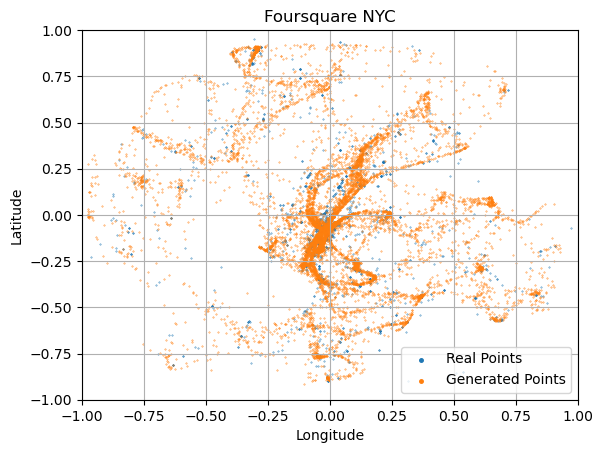

In [6]:
# Generate PointCloud
n_points = 10000
z = torch.randn((n_points, point_gan_fs.noise_dim, 1), device=point_gan_fs.device)

# Generate Points
gen_points = point_gan_fs(z).detach()
print(f"Generated Points:\t\t{gen_points.shape}")
gen_points = gen_points.view(-1, 2)
print(f"Generated Points:\t\t{gen_points.shape}")

# Real Points
real_points = next(iter(fs_loader))[0].view(-1, 2)
# Select n_points from real points
real_points = real_points[torch.randperm(real_points.shape[0])[:n_points]]
print(f"Real Points:\t\t\t{real_points.shape}")

# Plot Pointsclouds
visualise.plot_pointclouds(
    [real_points.cpu().numpy(), gen_points.cpu().numpy()],
    "Foursquare NYC",
    labels=["Real Points", "Generated Points"],
)

## FourSquare Dataset Trajectory

In [7]:
# Trajectory Model
MODEL_NAME = "GTG-GAN-FS"
N_EPOCHS = 1000

traj_gan_fs = GeoTrajGAN(
    gpu=GPU,
    name=MODEL_NAME,
    sequential_mode=True,
    use_traj_discriminator=True,
    generator_lstm=True
)
# Load Model
traj_gan_fs.load_parameters(epoch=N_EPOCHS)

[2024-02-04 16:02:20,552][INFO   ] Generator:
| Parameter          | Value     |
|--------------------|-----------|
| n_dim              | 2         |
| Uses PointNet      | True      |
| Code Size          | 256       |
| Normalization      | layer     |
| Activation         | ReLU()    |
| Mode               | linear    |
| Sequential Mode    | True      |
| Use LSTM           | True      |
| LSTM Latent Dim    | 64        |
| Bidirectional LSTM | True      |
| Merge Mode         | sum       |
| Parameters         | 2,073,826 | (geotrajgan.py:271) 
[2024-02-04 16:02:20,571][WARNING] [DIS] LSTM for per-trajectory feedback entirely separate from per-point feedback. (geotrajgan.py:512) 
[2024-02-04 16:02:20,575][INFO   ] Discriminator:
| Parameter          | Value     |
|--------------------|-----------|
| n_dim              | 2         |
| Uses STN           | True      |
| Code Size          | 256       |
| Normalization      | layer     |
| Activation         | ReLU()    |
| Mode    

Generated Trajectories:		torch.Size([1000, 30, 2])
Real Trajectory:			torch.Size([24, 2])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Foursquare NYC'}, xlabel='Longitude', ylabel='Latitude'>)

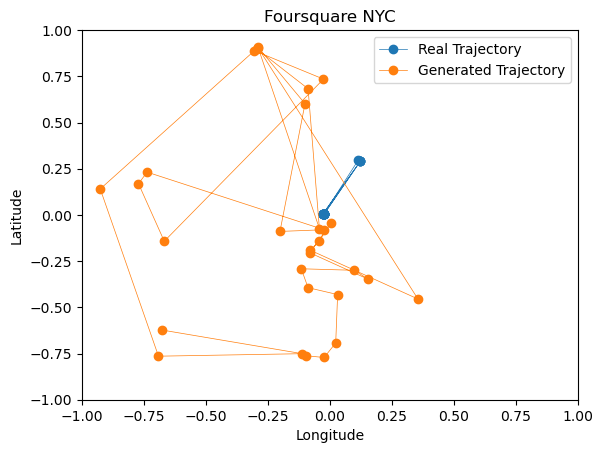

In [8]:
# Generate Trajectories
n_traj = 1000
seq_len = 30
z = torch.randn((n_traj, seq_len, traj_gan_fs.noise_dim), device=traj_gan_fs.device)

# Generate Trajectories
gen_traj = traj_gan_fs(z).detach()
print(f"Generated Trajectories:\t\t{gen_traj.shape}")

# Pick on Real Trajectory
real_traj = fs_dataset[random.randint(0, len(fs_dataset))][0]
print(f"Real Trajectory:\t\t\t{real_traj.shape}")

# Plot Trajectories
visualise.plot_trajectories(
    [real_traj.cpu().numpy(), gen_traj[random.randint(0, len(gen_traj))].cpu().numpy()],
    labels=["Real Trajectory", "Generated Trajectory"],
    title= "Foursquare NYC",
    bbox=(-1, 1, -1, 1)
)


Real Trajectories:			torch.Size([21099, 2])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Foursquare NYC'}, xlabel='Longitude', ylabel='Latitude'>)

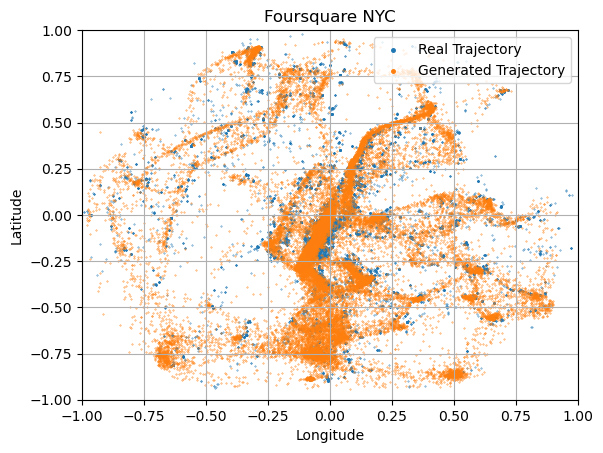

In [9]:
# Plot Point Cloud
# Pick n_traj real trajectories
idx = torch.randperm(len(fs_dataset))[:n_traj]
real_trajs = torch.cat([fs_dataset[i][0] for i in idx], dim=0)
print(f"Real Trajectories:\t\t\t{real_trajs.shape}")
gen_trajs = gen_traj.view(-1, 2).cpu()


visualise.plot_pointclouds(
    [real_trajs, gen_trajs],
    "Foursquare NYC",
    labels=["Real Trajectory", "Generated Trajectory"],
)

## Geolife Dataset Point

In [10]:
# Load GL Dataset
gl_dataset = dataset = get_dataset(
            dataset_name="geolife",
            mode=DatasetModes.ALL,
            latlon_only=True,
            normalize=True,
            return_labels=True,
            keep_original=False
        )
gl_dataloader = DataLoader(dataset,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    collate_fn=ZeroPadding(return_len=True, return_labels=True),
    pin_memory=True
    )

print("Training Samples:\t\t\t\t", len(gl_dataset))
print("Reference Point:\t\t\t\t", gl_dataset.reference_point)
print("Scaling Factor:\t\t\t\t\t", gl_dataset.scale_factor)

print("Number of Batches per epoch:\t", len(gl_dataloader))
print("Shape of a Batch:\t\t\t\t", next(iter(gl_dataloader))[0].shape)

[2024-02-04 16:02:24,285][WARNING] Make sure the reference point and scale factor computed during pre-processing are used! (geolife.py:122) 
[2024-02-04 16:02:24,287][INFO   ] Reading trajectories from '/home/erik/project2/data/geolife_FIFTH-RING_5_60_200_TRUNCATE'. (geolife.py:129) 
Training Samples:				 69504
Reference Point:				 [116.37499995, 39.89000165]
Scaling Factor:					 [0.18499995, 0.13999835]
Number of Batches per epoch:	 271
Shape of a Batch:				 torch.Size([256, 200, 2])


In [11]:
# Point Model
MODEL_NAME = "Geolife-Point-GTG-Baseline"
N_EPOCHS = 1000

point_gan_gl = GeoTrajGAN(
    gpu=GPU,
    name=MODEL_NAME,
    sequential_mode=False
)

# Load Model
try :
    point_gan_gl.load_parameters(epoch=N_EPOCHS)
except FileNotFoundError:
    print("Training not finished yet.")

[2024-02-04 16:02:25,612][INFO   ] Generator:
| Parameter       | Value     |
|-----------------|-----------|
| n_dim           | 2         |
| Uses PointNet   | True      |
| Code Size       | 256       |
| Normalization   | layer     |
| Activation      | ReLU()    |
| Mode            | linear    |
| Sequential Mode | False     |
| Use LSTM        | False     |
| Parameters      | 1,505,190 | (geotrajgan.py:271) 
[2024-02-04 16:02:25,629][INFO   ] Discriminator:
| Parameter         | Value     |
|-------------------|-----------|
| n_dim             | 2         |
| Uses STN          | True      |
| Code Size         | 256       |
| Normalization     | layer     |
| Activation        | ReLU()    |
| Mode              | linear    |
| Sequential Mode   | False     |
| LSTM at Start     | False     |
| Trajectory Critic | False     |
| Trajectory STN    | False     |
| Parameter Count:  | 1,405,733 | (geotrajgan.py:526) 
[2024-02-04 16:02:25,635][INFO   ] Discriminator Parameters:	1,405,7

Generated Points:		torch.Size([30000, 1, 2])
Generated Points:		torch.Size([30000, 2])
Real Points:			torch.Size([30000, 2])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'GeoLife'}, xlabel='Longitude', ylabel='Latitude'>)

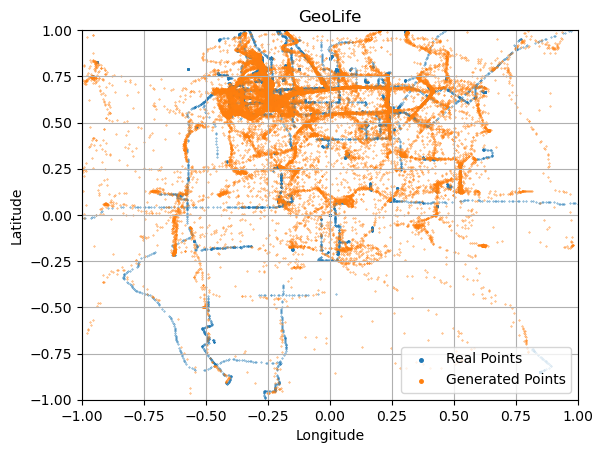

In [12]:
# Generate PointCloud
n_points = 30000
z = torch.randn((n_points, point_gan_gl.noise_dim, 1), device=point_gan_gl.device)

# Generate Points
gen_points = point_gan_gl(z).detach()
print(f"Generated Points:\t\t{gen_points.shape}")
gen_points = gen_points.view(-1, 2)
print(f"Generated Points:\t\t{gen_points.shape}")

# Real Points
real_points = next(iter(gl_dataloader))[0].view(-1, 2)
# Select n_points from real points
real_points = real_points[torch.randperm(real_points.shape[0])[:n_points]]
print(f"Real Points:\t\t\t{real_points.shape}")

# Plot Pointsclouds
visualise.plot_pointclouds(
    [real_points.cpu().numpy(), gen_points.cpu().numpy()],
    "GeoLife",
    labels=["Real Points", "Generated Points"],
)

## Geolife Dataset Trajectory

In [13]:
# Trajectory Model
MODEL_NAME = "GTG-GAN-GL"
N_EPOCHS = 1000

traj_gan_gl = GeoTrajGAN(
    gpu=GPU,
    name=MODEL_NAME,
    sequential_mode=True,
    use_traj_discriminator=True,
    generator_lstm=True
)
# Load Model
try:
    traj_gan_gl.load_parameters(epoch=N_EPOCHS)
except FileNotFoundError:
    print("Training not finished yet.")

[2024-02-04 16:02:29,047][INFO   ] Generator:
| Parameter          | Value     |
|--------------------|-----------|
| n_dim              | 2         |
| Uses PointNet      | True      |
| Code Size          | 256       |
| Normalization      | layer     |
| Activation         | ReLU()    |
| Mode               | linear    |
| Sequential Mode    | True      |
| Use LSTM           | True      |
| LSTM Latent Dim    | 64        |
| Bidirectional LSTM | True      |
| Merge Mode         | sum       |
| Parameters         | 2,073,826 | (geotrajgan.py:271) 
[2024-02-04 16:02:29,065][WARNING] [DIS] LSTM for per-trajectory feedback entirely separate from per-point feedback. (geotrajgan.py:512) 
[2024-02-04 16:02:29,069][INFO   ] Discriminator:
| Parameter          | Value     |
|--------------------|-----------|
| n_dim              | 2         |
| Uses STN           | True      |
| Code Size          | 256       |
| Normalization      | layer     |
| Activation         | ReLU()    |
| Mode    

Generated Trajectories:		torch.Size([1000, 30, 2])
Real Trajectory:			torch.Size([173, 2])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Geolife'}, xlabel='Longitude', ylabel='Latitude'>)

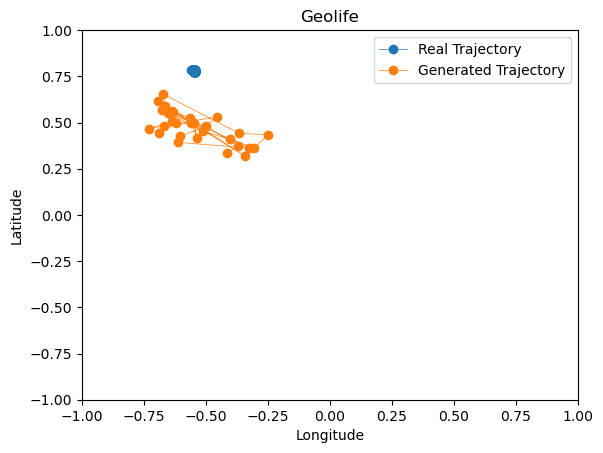

In [14]:
# Generate Trajectories
n_traj = 1000
seq_len = 30
z = torch.randn((n_traj, seq_len, traj_gan_gl.noise_dim), device=traj_gan_gl.device)

# Generate Trajectories
gen_traj = traj_gan_gl(z).detach()
print(f"Generated Trajectories:\t\t{gen_traj.shape}")

# Pick on Real Trajectory
real_traj = gl_dataset[random.randint(0, len(gl_dataset))][0]
print(f"Real Trajectory:\t\t\t{real_traj.shape}")

# Plot Trajectories
visualise.plot_trajectories(
    [real_traj.cpu().numpy(), gen_traj[random.randint(0, len(gen_traj))].cpu().numpy()],
    labels=["Real Trajectory", "Generated Trajectory"],
    title= "Geolife",
    bbox=(-1, 1, -1, 1)
)

Real Trajectories:			torch.Size([94870, 2])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Geolife'}, xlabel='Longitude', ylabel='Latitude'>)

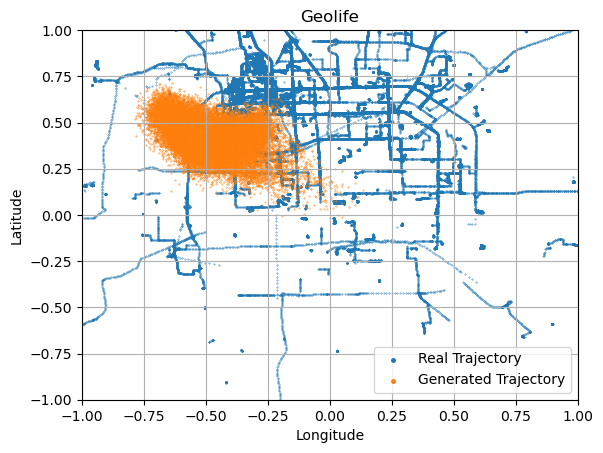

In [15]:
# Plot Point Cloud
# Pick n_traj real trajectories
idx = torch.randperm(len(gl_dataset))[:n_traj]
real_trajs = torch.cat([gl_dataset[i][0] for i in idx], dim=0)
print(f"Real Trajectories:\t\t\t{real_trajs.shape}")

# Pick n_traj generated trajectories
gen_trajs = gen_traj.view(-1, 2).cpu()

visualise.plot_pointclouds(
    [real_trajs, gen_trajs],
    "Geolife",
    labels=["Real Trajectory", "Generated Trajectory"],
)